In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pa.npy')
a,ale,ahe = Highest_density_region(px,x)

time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)

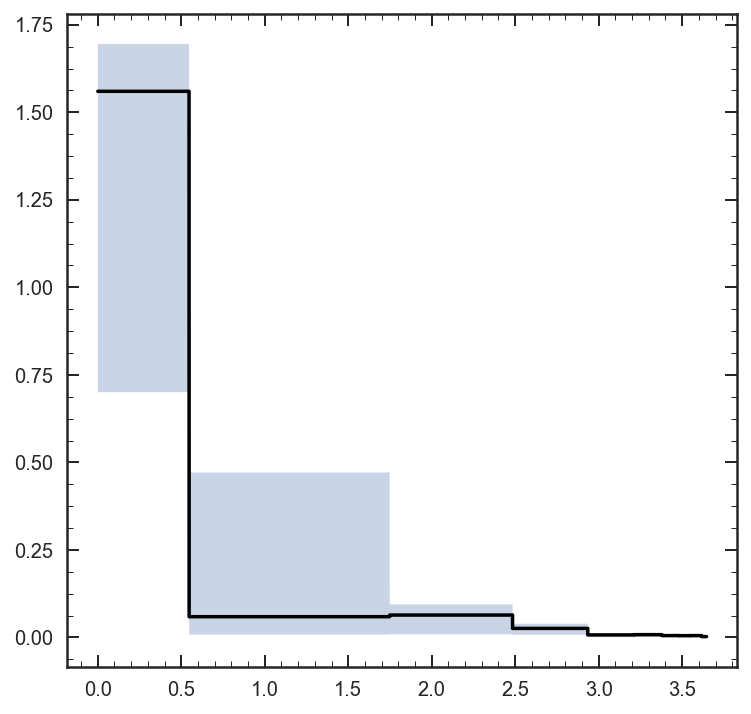

In [94]:
plt.figure(figsize=[6,6])
plt.plot(time,sfr,'k')
# plt.plot(time,sfr_l,'k')
# plt.plot(time,sfr_h,'k')
plt.fill_between(time,sfr_l, sfr_h, alpha = 0.3)


In [95]:
MB = [0]
T=[0]
m=0
IMB = []
for i in range(len(time)//2):
    m+=sfr[i*2+1] * (time[i*2+1] - time[i*2])
    IMB.append(sfr[i*2+1] * (time[i*2+1] - time[i*2]))
    MB.append(m)
    T.append(time[i*2+1])

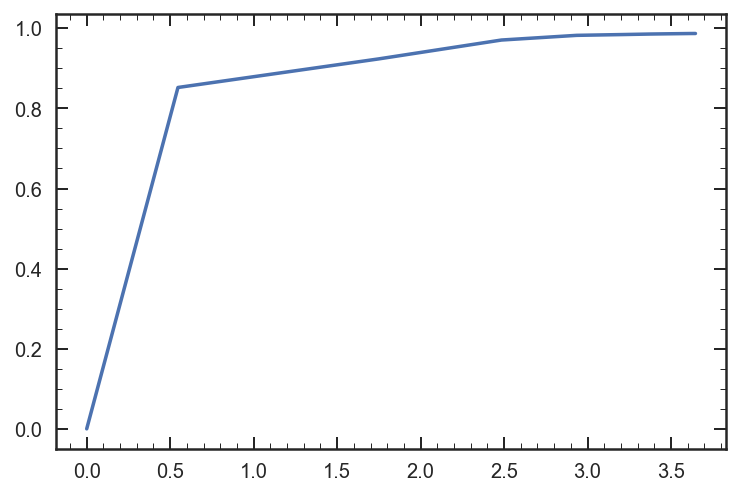

In [101]:
plt.plot(T,MB)

In [97]:
sum(IMB[1:])

0.13479114941362091

In [98]:
newx = np.arange(T[1],T[-1]+0.001,0.001)
tau = np.arange(0.001,1,0.001)

mass = []
for i in tau: 
    k = sfr[1] / max(np.exp(-newx / i))
    expfit = np.exp(-newx / i) * k
    mass.append(np.trapz(expfit,newx))
#     plt.plot(newx, expfit)
#     plt.plot(time,sfr ,'k')


array(0.08640263)

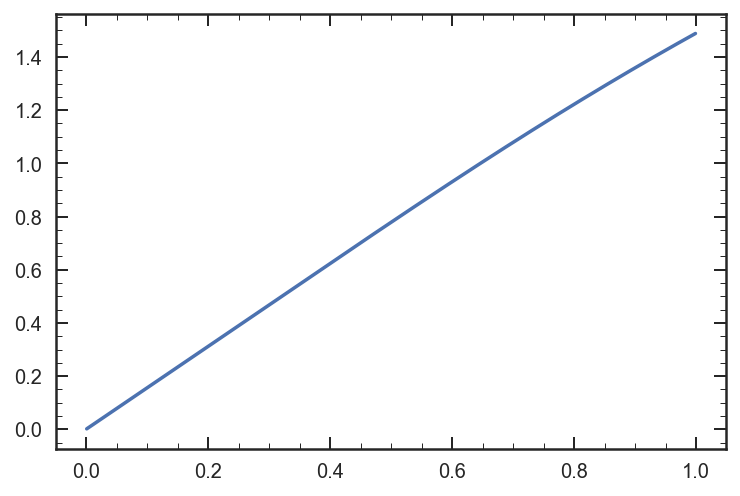

In [99]:
plt.plot(tau,mass)
interp1d(mass,tau)(sum(IMB[1:]))

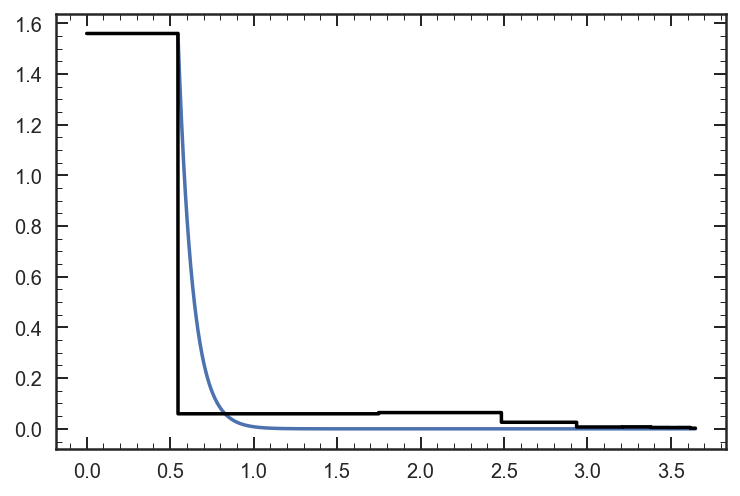

In [100]:
outtau = interp1d(mass,tau)(sum(IMB[1:]))
k = sfr[1] / max(np.exp(-newx /outtau))
expfit = np.exp(-newx / outtau) * k
plt.plot(newx, expfit)
plt.plot(time,sfr ,'k')

In [3]:
def Get_tau(field, galaxy):
    
    med = np.zeros(10)
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy, i+1))
        med[i] = x[px == px.max()][0]

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
    a = x[px == px.max()][0]

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    
    T=[0]
    IMB = []
    for i in range(len(time)//2):
        IMB.append(sfr[i*2+1] * (time[i*2+1] - time[i*2]))
        T.append(time[i*2+1])
    
#     newx = np.arange(T[1],T[-1]+0.001,0.001)
#     tau = np.arange(0.001,1,0.001)

#     mass = []
#     for i in tau: 
#         k = sfr[1] / max(np.exp(-newx / i))
#         expfit = np.exp(-newx / i) * k
#         mass.append(np.trapz(expfit,newx))

#     return interp1d(mass,tau)(sum(IMB[1:]))
    return sum(IMB[1:])


In [4]:
Get_tau('GSD',39170)

0.002673900707442327

# get size

In [13]:
# goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodss_fast = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_fast = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()


In [14]:
flist = glob('../data/posteriors/*zfit*')

fld = [os.path.basename(U).split('_')[0] for U in flist] 
ids = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(int)

In [18]:
Reff = []
lmass = []
taus = []
rshift = []

for i in range(len(fld)):
    try:
        taus.append(Get_tau(fld[i],ids[i]))
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(fld[i], ids[i]))
        rshift.append(x[px==px.max()][0])

        if fld[i][1] == 'S':
            r = goodss_rad.re[goodss_rad.NUMBER == ids[i]].values * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == ids[i]].values)
            Reff.append(r[0])
            lmass.append(goodss_fast.lmass[goodss_fast.id == ids[i]].values[0])
        if fld[i][1] == 'N':
            r = goodsn_rad.re[goodsn_rad.NUMBER == ids[i]].values * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == ids[i]].values)
            Reff.append(r[0])
            lmass.append(goodsn_fast.lmass[goodsn_fast.id == ids[i]].values[0])
            
    except:
        print('skip {0}_{1}'.format(fld[i], ids[i]))


    

array([11.01])

In [19]:
taus = np.array(taus)
Reff = np.array(Reff)
rshift = np.array(rshift)
lmass = np.array(lmass)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


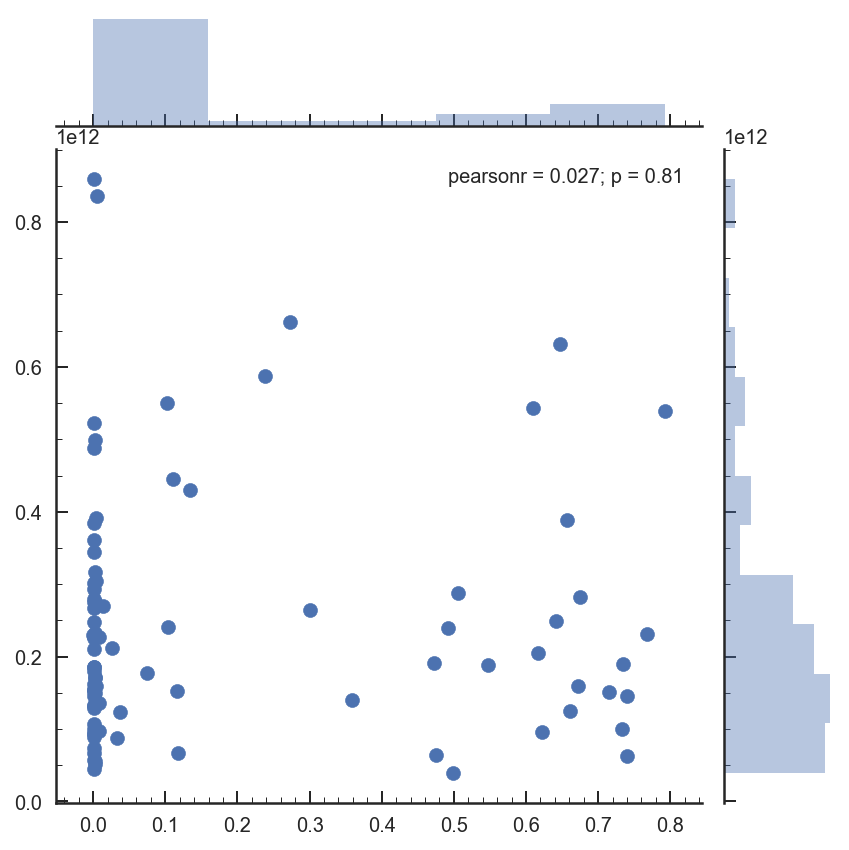

In [26]:
sea.jointplot(taus[Reff < 1],(10**lmass/Reff)[Reff < 1])
# plt.ylim(0,1)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


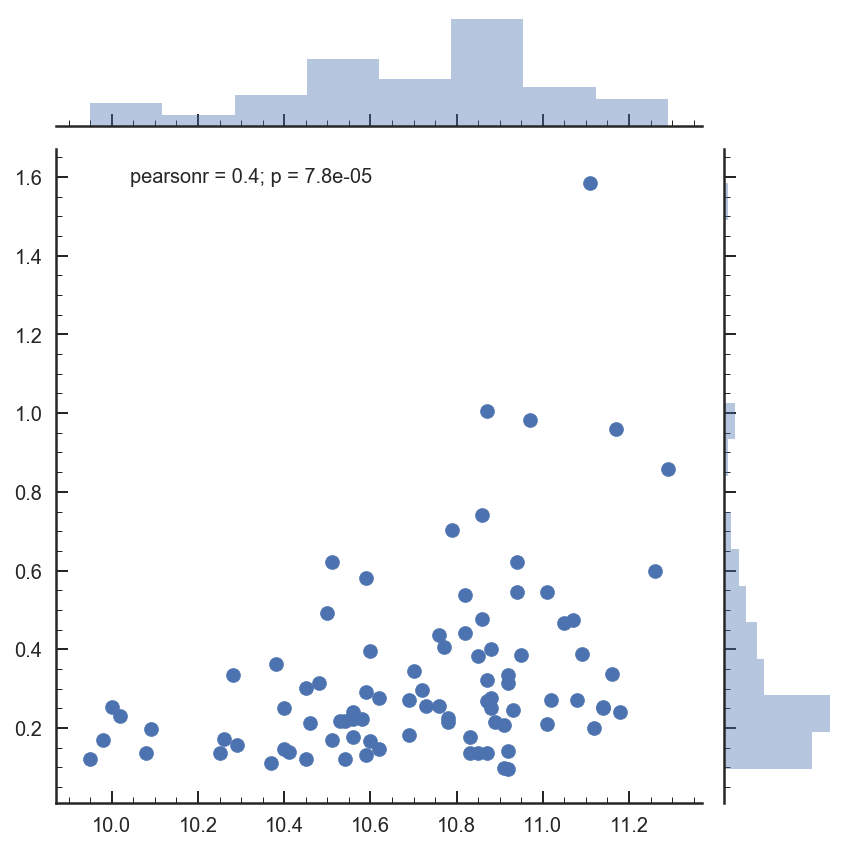

In [28]:
sea.jointplot(lmass[Reff < 2],Reff[Reff < 2])


In [23]:
np.log10(10**lmass/Reff)

array([11.17813553, 10.98138317, 10.7554702 , 11.4265139 , 10.82131152,
       11.31151212, 11.39641696, 10.59558833, 11.58428953, 11.93437142,
       11.16229852, 10.94651284, 11.69802931, 11.63279354, 11.71789362,
       11.17500904, 11.28099572, 11.44052467, 11.08928348, 11.47913715,
       10.86451903, 11.18967088, 10.97803663, 10.82623626, 11.12471931,
       11.00150433, 11.59235045, 11.16385629, 11.24832525, 11.11953184,
       11.48270771, 11.26758388, 11.21002793, 10.9694042 , 11.35641983,
       11.20256527, 11.02678825, 11.23250395, 11.53725158, 10.94375046,
       10.65554064, 11.20377943, 10.99933509, 11.36217488, 11.18836455,
       11.44564788, 11.55762777, 11.38195112, 11.26715629, 11.11139313,
       11.39295967, 11.2332925 , 11.13295416, 11.73499725, 11.18243352,
       11.37929388, 11.74075173, 11.36699433, 11.4505917 , 10.98999967,
       10.56289017, 11.09786029, 11.36319852, 11.27734791, 11.50151655,
       11.43999468, 11.82093788, 11.25701107, 11.9223392 , 11.18